In [3]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from tqdm import tqdm

pd.set_option('display.max_columns', None)

## Reading and data cleaning

In [4]:
df_p1 = pd.read_csv("data1.csv")
df_p2 = pd.read_csv("data2.csv")
df_p3 = pd.read_csv("data70_140.csv")
df_p4 = pd.read_csv("data140_210.csv")
df_p5 = pd.read_csv("data210_310.csv")
df_p6 = pd.read_csv("data310_410.csv")

df = pd.concat([df_p1, df_p2, df_p3, df_p4, df_p5, df_p6]).drop_duplicates()

df = df.rename(columns={"orientation.1":"orientation_desc", "floor.1":"floor_desc", "antiquity.1":"antiquity_desc", "conservationState.1":"conservationState_desc", "hotWater.1":"hotWater_type_desc", "heating.1":"heating_desc"})
bool_features_cols = [
    'furnished','parking', 'Aire acondicionado', 'Parquet', 'Horno', 'Microondas',
    'Serv. portería', 'Balcón', 'Lavadero', 'Armarios', 'Calefacción',
    'Suite - con baño', 'Nevera', 'Puerta Blindada', 'Terraza',
    'Electrodomésticos', 'Alarma', 'Cocina Equipada', 'Lavadora',
    'Cocina Office', 'Patio', 'Videoportero', 'Piscina', 'Gres Cerámica',
    'Jardín Privado', 'Trastero', 'Internet', 'Domótica', 'TV',
    'Ascensor interior', 'Sistema Video vigilancia CCTV 24h',
    'Z. Comunitaria', 'Zona Deportiva', 'Zona Infantil',
    'Piscina comunitaria', 'Gimnasio', 'Baño de huéspedes',
    'Cuarto para el servicio', 'Jacuzzi', 'Bodega', 'Sauna',
    'Cuarto lavado plancha', 'Energía Solar', 'elevator', 'Pista de Tenis', 'Porche cubierto'
] # df.columns[45:87]

for colname in bool_features_cols:
    df[colname] = np.where(df[colname]>0, True, False)

df = df[df["value"]>0]
df = df[df["value"].notna()]
df = df[(df["surface"]>0) & (df["surface"].notna())]
print(df.shape)

(9530, 114)


In [5]:
print(list(set(df.dtypes.to_list())))
# what to do with columns
# after consifderation, we decide to prevaler the descriptive features, as they are more reliable and give more information
# this can affect to the future, forcing us to do a data transformation of for example "6ª planta" to 6.
# hence, we drop the following 'int64' columns:
# type, transactions, transaction_type, periodicity_id, energyCertificate, surfaceLand, countryId, level1Id	level2Id	level3Id	level4Id	level5Id	level6Id	level7Id	level8Id
#         conservationState, orientation, hotwater, heating, antiquity, floor,
cols_drop = ["transactions", "transaction_type", "periodicity_id", "energyCertificate", "surfaceLand", "countryId", "level1Id",
             "level2Id", "level3Id", "level4Id", "level5Id", "level6Id", "level7Id", "level8Id",
             "conservationState", "orientation", "hotWater", "heating", "antiquity"] # , "floor"
try:
    df = df.drop(columns=cols_drop)
except:
    print("Some error ocurred. Maybe already dropped columns")


[dtype('O'), dtype('float64'), dtype('int64'), dtype('bool')]


### Outliers removal

In [6]:
# Tukey's method is based on interquartile range (IQR) and is robust to skewed distributions, while the z-score method 
# relies on mean and standard deviation and is sensitive to extreme values. The choice between these methods depends 
# on the nature of your data and the specific requirements of your analysis. It's often a good practice to try both 
# methods and compare their effects on your data.

def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def remove_outliers_zscore(df, column, threshold=2):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores < threshold]

df_iqr = remove_outliers_iqr(df, "value")
df_z = remove_outliers_zscore(df, "value")

print(f"IQR: {len(df_iqr)} | Actual: {len(df)} | {(len(df_iqr)/len(df))*100:.2f}%")
print(f"IQR: {len(df_z)} | Actual: {len(df)} | {(len(df_z)/len(df))*100:.2f}%")

IQR: 8753 | Actual: 9530 | 91.85%
IQR: 9210 | Actual: 9530 | 96.64%


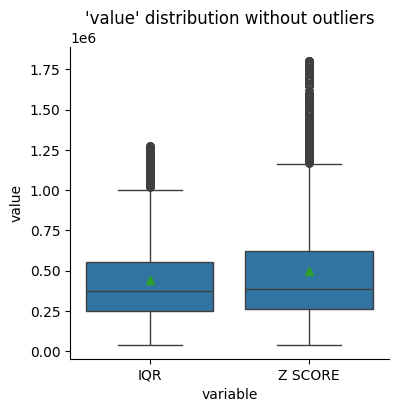

In [7]:
df_iqr = df_iqr.copy()
df_z = df_z.copy()

df_iqr['variable'] = 'IQR'
df_z['variable'] = 'Z SCORE'
combined_df = pd.concat([df_iqr, df_z], axis=0)
sns.catplot(data=combined_df, kind='box', x='variable', y='value', showmeans=True, height=4, aspect=1)
plt.title("'value' distribution without outliers")
plt.show()

In [8]:
df1 = df_iqr.reset_index(drop=True)

## Exploratory Data Analysis

In [9]:
df_des = df1.select_dtypes(include = ['O'])
df_num = df1.select_dtypes(include = ['int64','float64'])
df_bool = df1.select_dtypes(include = ['bool'])

### General Plots

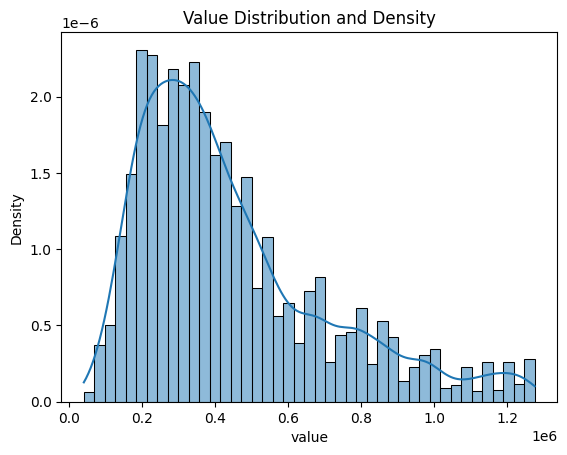

mean      442472.519708
median    375000.000000
std       260142.904088
count       8753.000000
Name: value, dtype: float64

In [10]:
# The main variable: Value
sns.histplot(df1.value, kde=True, stat="density")
plt.title("Value Distribution and Density")
plt.show()
df1['value'].agg(['mean', 'median', 'std', 'count'])

Hyphothesis of main variables: floor, square meters, neighborhood, antiquity, number of rooms

What we see:
- floor_desc

In [11]:
des_plot_features = ["orientation_desc","antiquity_desc","conservationState_desc","hotWater_type_desc","heating_desc"] # desc features
bool_plot_features = df_bool.columns

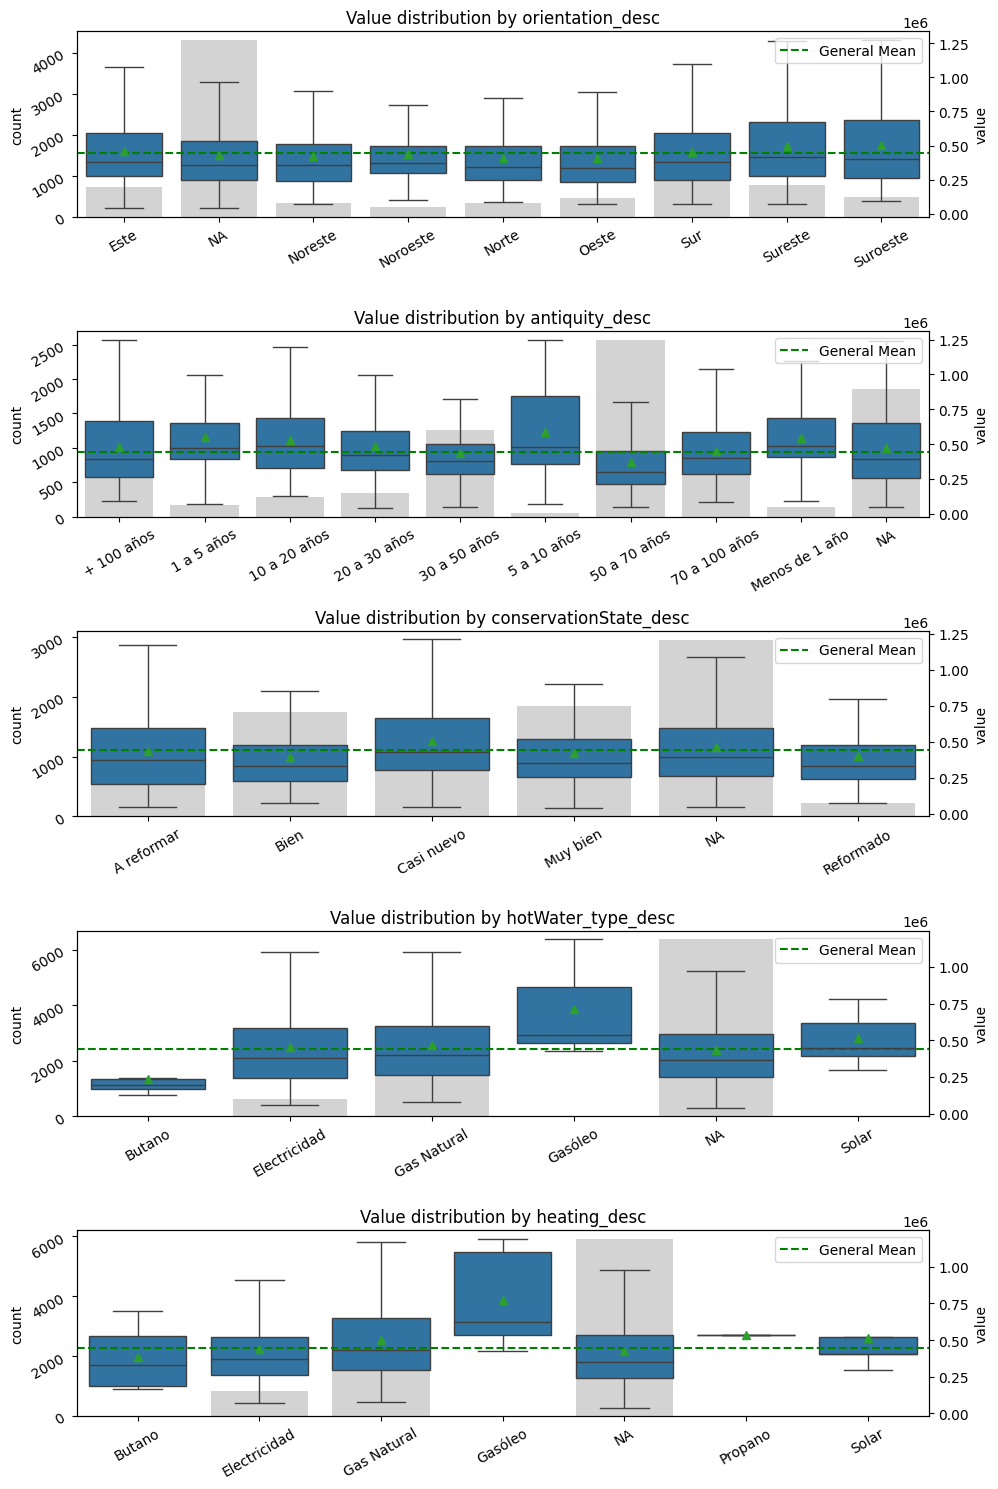

In [12]:
fig, ax1 = plt.subplots(nrows=len(des_plot_features), ncols=1, figsize=(10,len(des_plot_features)*3))

for i, feature in enumerate(des_plot_features):
    df_plot = df1[[feature, "value"]].fillna('NA').sort_values(feature)
    ax1[i].bar(df_plot[feature].unique(), df_plot.groupby(feature).size(), color='lightgrey')
    ax1[i].set_ylabel("count")
    ax2 = ax1[i].twinx()
    sns.boxplot(data=df_plot, x=feature, y='value', showfliers=False, showmeans=True, ax=ax2)
    plt.axhline(y=df_plot['value'].mean(), color='g', linestyle='--', label='General Mean')
    ax1[i].tick_params(labelrotation=30)
    plt.legend(loc="upper right")
    plt.title(f"Value distribution by {feature}")

plt.tight_layout()
plt.show()

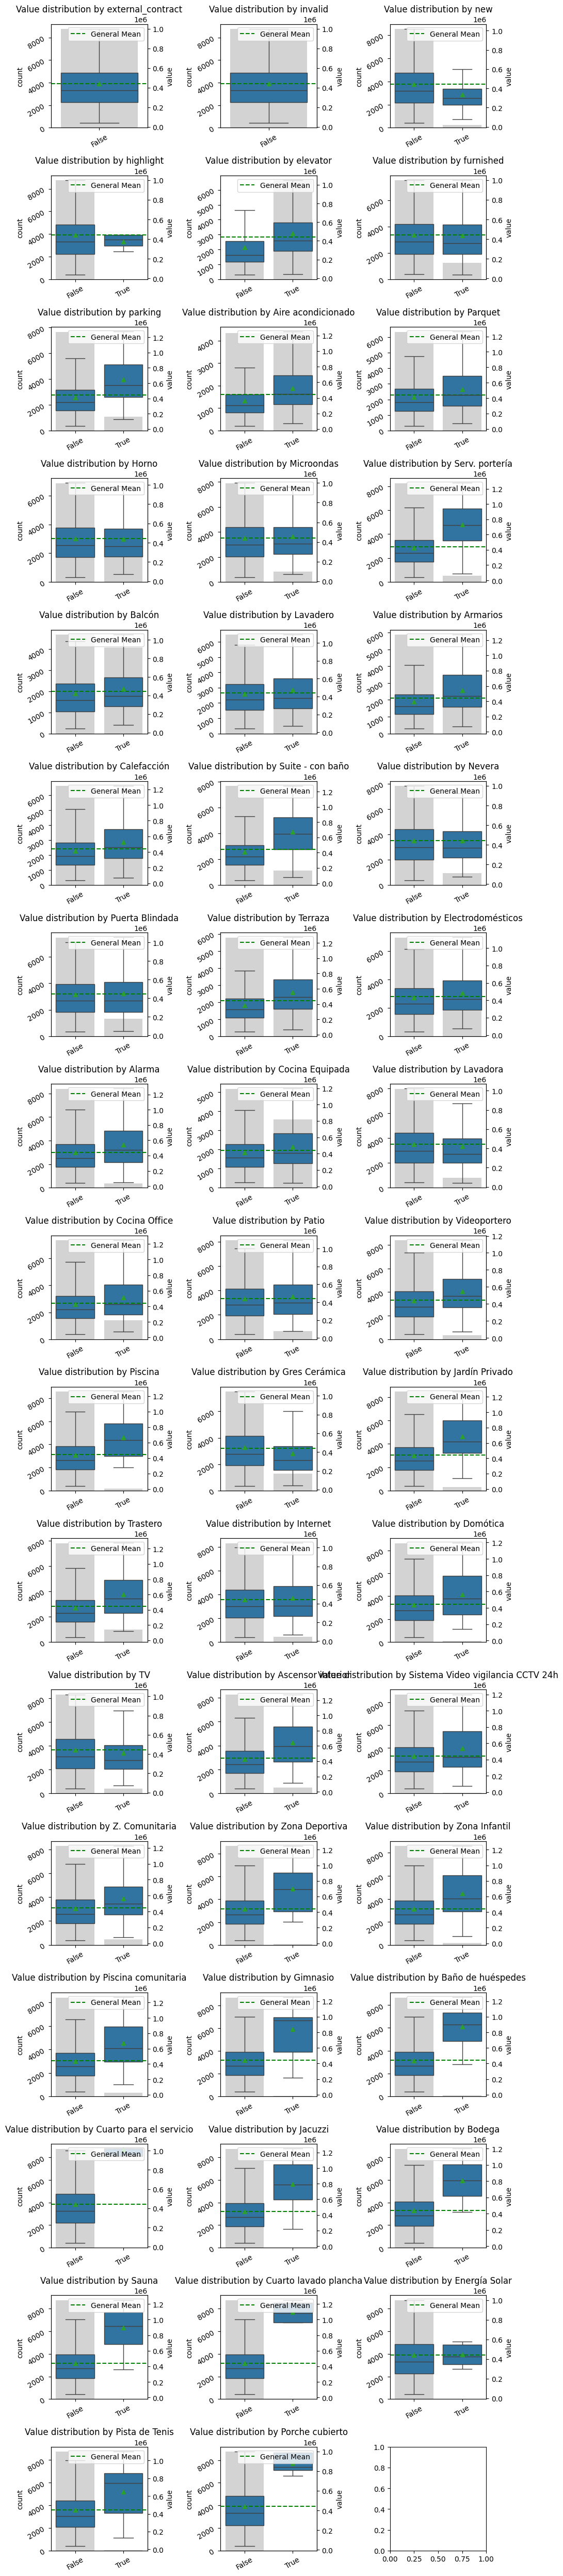

In [13]:
fig, ax1 = plt.subplots(nrows=int(np.ceil(len(bool_plot_features)/3)), ncols=3, figsize=(10,len(bool_plot_features)))

for i, feature in enumerate(bool_plot_features):
    df_plot = df1[[feature, "value"]].fillna('NA').sort_values(feature)
    ax1 = ax1.ravel()
    ax1[i].bar(df_plot[feature].unique(), df_plot.groupby(feature).size(), color='lightgrey')
    ax1[i].set_ylabel("count")
    ax2 = ax1[i].twinx()
    sns.boxplot(data=df_plot, x=feature, y='value', showfliers=False, showmeans=True, ax=ax2)
    plt.axhline(y=df_plot['value'].mean(), color='g', linestyle='--', label='General Mean')
    ax1[i].tick_params(labelrotation=30)
    plt.legend(loc="upper right")
    plt.title(f"Value distribution by {feature}")

plt.tight_layout()
plt.show()

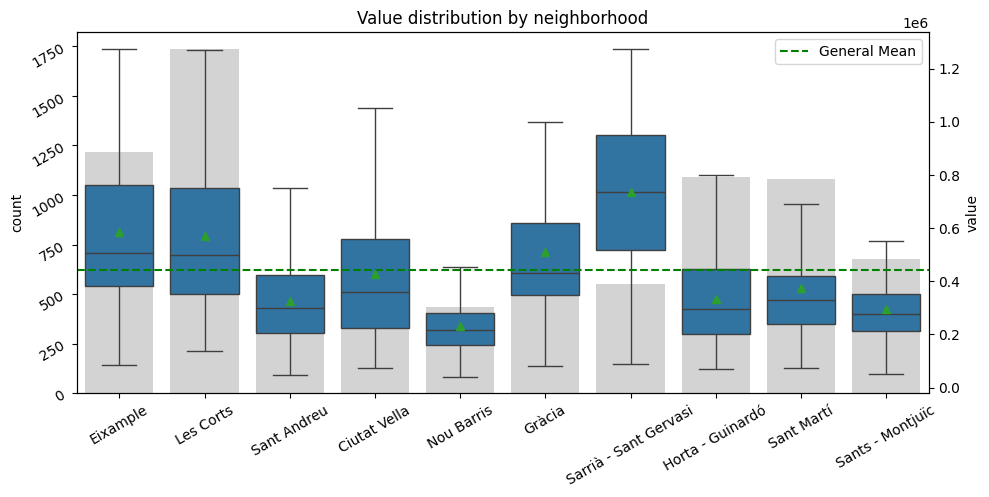

In [48]:
df_level_plot = df1[["level7", "value"]].fillna('NA')
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(df_level_plot['level7'].unique(), df_level_plot.groupby('level7').size(), color='lightgrey')
ax1.set_ylabel("count")
ax2 = ax1.twinx()
sns.boxplot(data=df_level_plot, x='level7', y='value', showfliers=False, showmeans=True, ax=ax2)
plt.axhline(y=df_level_plot['value'].mean(), color='g', linestyle='--', label='General Mean')
ax1.tick_params(labelrotation=30)
plt.tight_layout()
plt.legend()
plt.title("Value distribution by neighborhood")
plt.show()


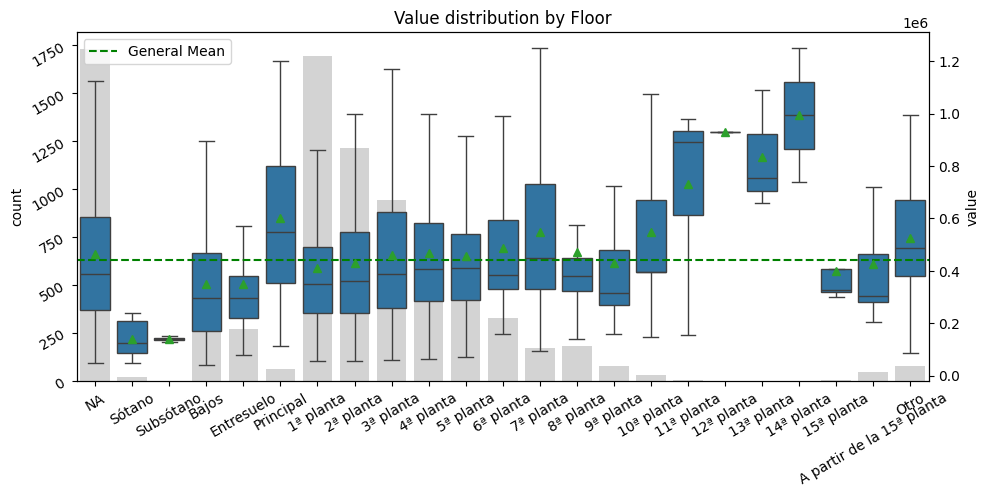

In [47]:
df_floor_plot = df1[["floor_desc", "value", "floor"]].fillna('NA').sort_values('floor')
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(df_floor_plot['floor_desc'].unique(), df_floor_plot.groupby('floor').size(), color='lightgrey')
ax1.set_ylabel("count")
ax2 = ax1.twinx()
sns.boxplot(data=df_floor_plot, x='floor_desc', y='value', showfliers=False, showmeans=True, ax=ax2)
plt.axhline(y=df_floor_plot['value'].mean(), color='g', linestyle='--', label='General Mean')
ax1.tick_params(labelrotation=30)
plt.tight_layout()
plt.legend()
plt.title("Value distribution by Floor")
plt.show()


In [16]:
# Explain why doing this type of mean
# np.mean(df1.value/df1.surface)
# np.mean(df1.value)/np.mean(df1.su
# np.sum(df1.value) / np.sum(df1.surface)rface)
# Es menos sensible a valores atípicos y variaciones extremas en los precios o tamaños de los pisos, ya que se basa en totales agregados.
# General mean is 4475.5086448770935
# Explain conclusion (583445.448674/107.054210)*138
stat = df1.groupby('level7')['value'].agg(['mean', 'count', 'sum']).rename(columns={"sum":"value_sum","mean":"value_mean"})
stat_value = df1.groupby('level7')['surface'].agg(['sum','mean']).rename(columns={"sum":"sqm_sum", "mean":"sqm_mean"})
stat_sqm = pd.merge(stat, stat_value, on='level7')
stat_sqm["value_per_sqm"] = stat_sqm["value_sum"] / stat_sqm["sqm_sum"]
stat_sqm.sort_values("value_per_sqm", ascending=False)

,value_mean,count,value_sum,sqm_sum,sqm_mean,value_per_sqm
level7,,,,,,
Eixample,583445.448674,1734,1011694408,185632,107.054210,5450.000043
Sarrià - Sant Gervasi,737300.612094,678,499889815,93653,138.131268,5337.680747
Les Corts,571462.670507,434,248014799,48582,111.940092,5105.075933
Gràcia,508503.010733,559,284253183,59203,105.908766,4801.330726
Ciutat Vella,428648.668581,1219,522522727,120482,98.836751,4336.936032
Sant Martí,374819.379689,1093,409677582,97553,89.252516,4199.538528
Sants - Montjuïc,293877.794635,1081,317681896,86941,80.426457,3653.994042
Sant Andreu,327332.257246,552,180687406,50016,90.608696,3612.592091
Horta - Guinardó,333597.407821,716,238855744,66258,92.539106,3604.934408


In [23]:
stat = df1.groupby('level8')['value'].agg(['mean', 'count', 'sum']).rename(columns={"sum":"value_sum","mean":"value_mean"})
stat_value = df1.groupby('level8')['surface'].agg(['sum','mean']).rename(columns={"sum":"sqm_sum", "mean":"sqm_mean"})
stat_sqm = pd.merge(stat, stat_value, on='level8')
stat_sqm["value_per_sqm"] = stat_sqm["value_sum"] / stat_sqm["sqm_sum"]
stat_sqm.sort_values("value_per_sqm", ascending=False).head(5)

,value_mean,count,value_sum,sqm_sum,sqm_mean,value_per_sqm
level8,,,,,,
Sarrià,709466.176471,68,48243700,7340,107.941176,6572.711172
La Clota,463666.666667,9,4173000,654,72.666667,6380.733945
Diagonal Mar i el Front Marítim del Poblenou,593941.200000,125,74242650,11832,94.656000,6274.733773
Dreta de l'Eixample,760797.608225,462,351488495,57332,124.095238,6130.755861
Pedralbes,814582.524272,103,83902000,13792,133.902913,6083.381671


In [75]:
# Calculating the deviation from general mean
value_general_mean = np.mean(df1.value)
surface_general_mean = np.mean(df1.surface)
stat_sqm["dev_value_general"] = stat_sqm["value_mean"] / value_general_mean
stat_sqm["dev_surface_general"] = stat_sqm["sqm_mean"] / surface_general_mean
stat_sqm["diff_ratios_unfairness"] = stat_sqm["dev_value_general"] / stat_sqm["dev_surface_general"]
stat_sqm = stat_sqm.sort_values("diff_ratios_unfairness", ascending=False)
stat_sqm[["value_mean","sqm_mean","value_per_sqm","dev_value_general","dev_surface_general", "diff_ratios_unfairness"]].head()


,value_mean,sqm_mean,value_per_sqm,dev_value_general,dev_surface_general,diff_ratios_unfairness
level8,,,,,,
Sarrià,709466.176471,107.941176,6572.711172,1.603413,1.091800,1.468595
La Clota,463666.666667,72.666667,6380.733945,1.047899,0.735007,1.425700
Diagonal Mar i el Front Marítim del Poblenou,593941.200000,94.656000,6274.733773,1.342323,0.957424,1.402016
Dreta de l'Eixample,760797.608225,124.095238,6130.755861,1.719423,1.255195,1.369846
Pedralbes,814582.524272,133.902913,6083.381671,1.840979,1.354397,1.359260


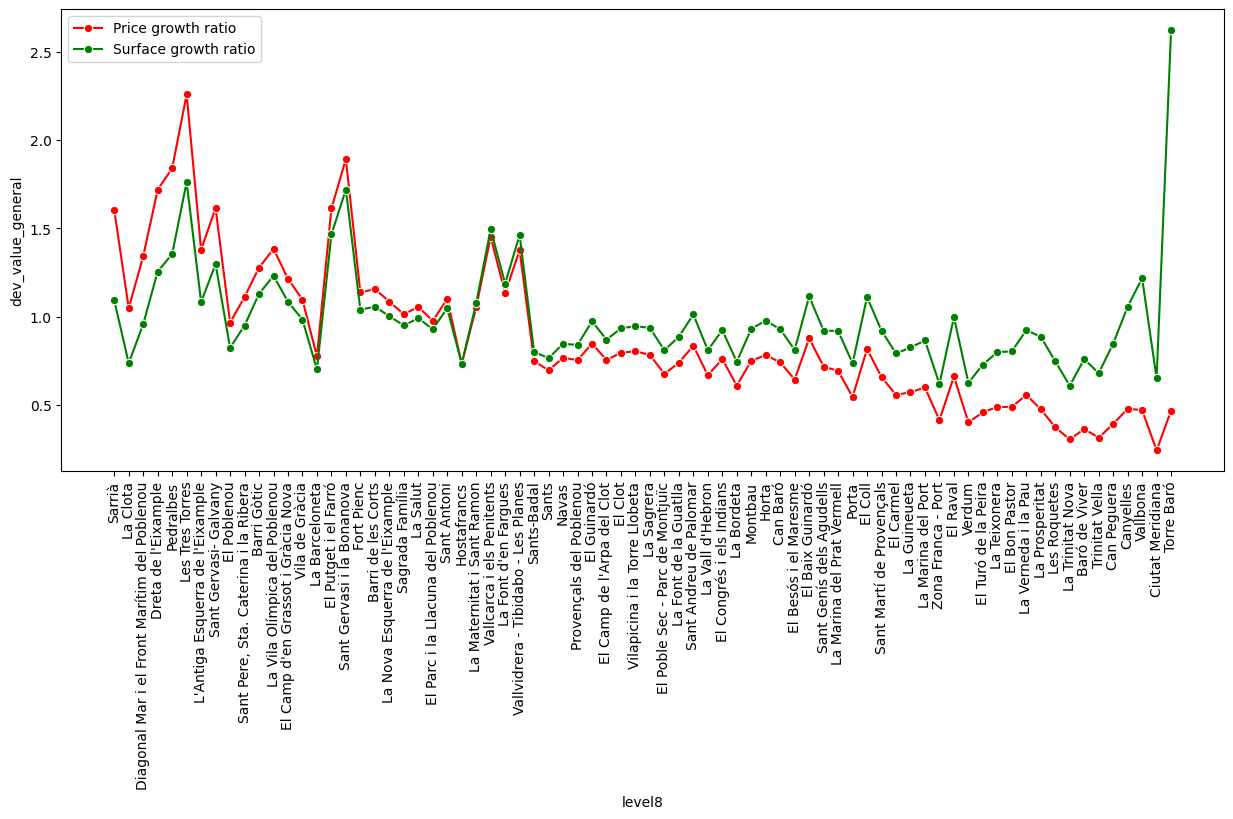

In [99]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=stat_sqm, x="level8", y="dev_value_general", marker='o', label="Price growth ratio", color="red")
sns.lineplot(data=stat_sqm, x="level8", y="dev_surface_general", marker='o', label="Surface growth ratio", color="green")
plt.legend()
plt.xticks(rotation=90)
plt.show()

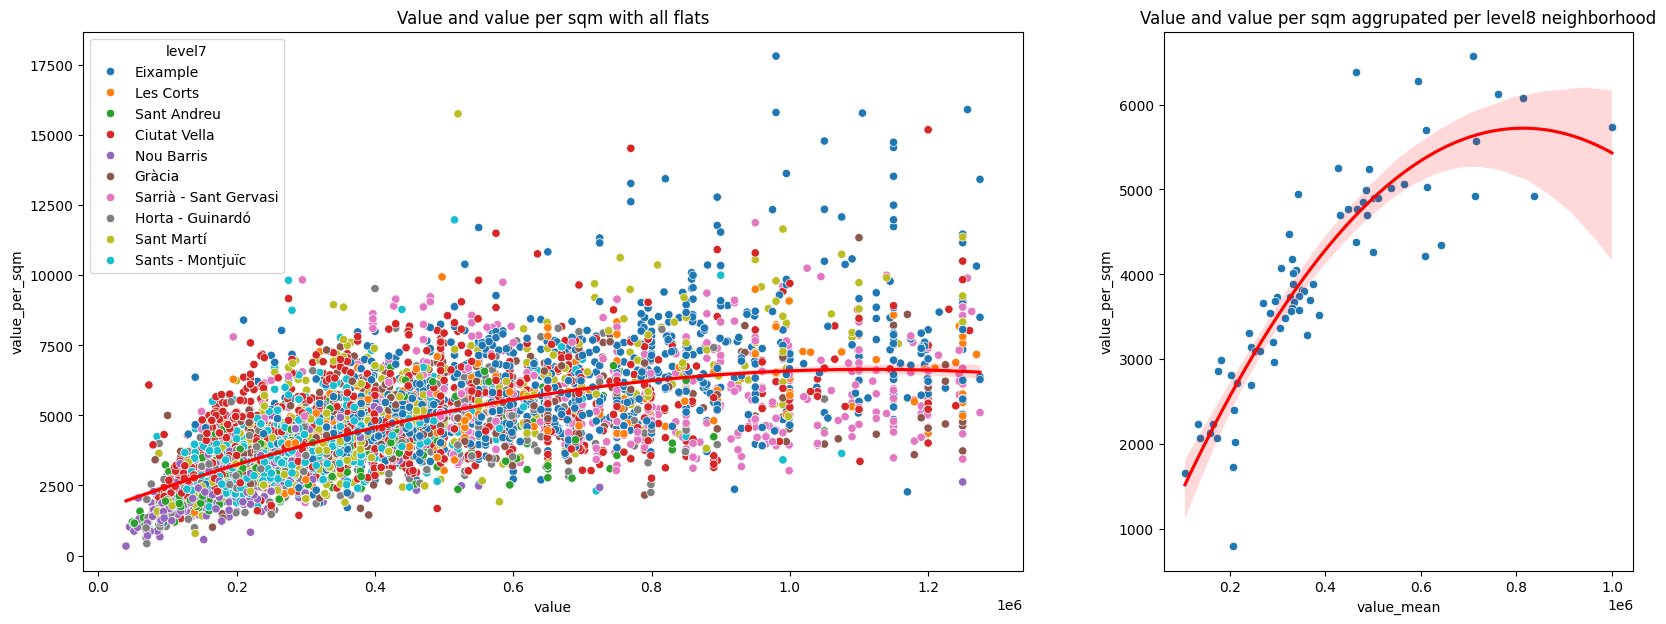

In [145]:
df1["value_per_sqm"] = df1["value"] / df1["surface"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7), gridspec_kw={'width_ratios': [2, 1]})
sns.scatterplot(data=df1, x="value", y="value_per_sqm", hue="level7", ax=ax[0])
sns.regplot(data=df1, x='value', y='value_per_sqm', scatter=False, color='red', order=2, label='Trendline', ax=ax[0])
ax[0].set_title("Value and value per sqm with all flats")
sns.scatterplot(data=stat_sqm, x="value_mean", y="value_per_sqm", ax=ax[1])
sns.regplot(data=stat_sqm, x='value_mean', y='value_per_sqm', scatter=False, color='red', order=2, label='Trendline', ax=ax[1])
ax[1].set_title("Value and value per sqm aggrupated per level8 neighborhood")
plt.show()

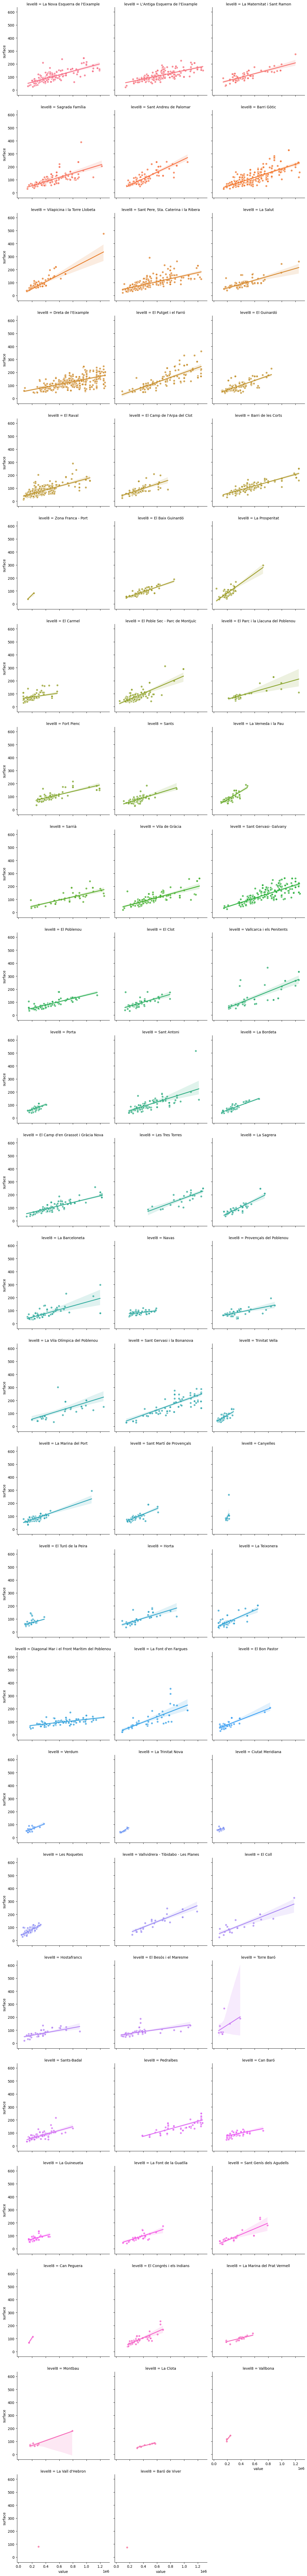

In [146]:
sns.lmplot(
    x="value", y="surface", hue="level8", col="level8",
    data=df1, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
)